In [1]:
!pip install conllu pandas matplotlib

In [2]:
import os
import glob
from conllu import parse_incr
from collections import defaultdict, Counter
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Path to directory containing the .conllu files
UD_DIR = "/content"

# Helper function to extract morphological features
def get_feats(token):
  feats = token.get("feats")
  return feats if isinstance(feats, dict) else {}

In [8]:
# Helper function to check agreement
def check_agreement(subj_feats, verb_feats):
    # Check agreement on both person and number (if available)
    agreed = True
    for feat in ["Number", "Person"]:
        if feat in subj_feats and feat in verb_feats:
            if subj_feats[feat] != verb_feats[feat]:
                agreed = False
    return agreed


In [9]:
# Data holders
results = defaultdict(lambda: Counter())
examples = defaultdict(lambda: {"agree": [], "disagree": []})

In [10]:
# Process each .conllu file
for filepath in glob.glob(os.path.join(UD_DIR, "*.conllu")):
    lang = os.path.basename(filepath).split("-")[0]
    with open(filepath, "r", encoding="utf-8") as f:
        for sent in parse_incr(f):
            id_to_token = {token["id"]: token for token in sent if isinstance(token["id"], int)}
            for token in sent:
                if token["deprel"] in ("nsubj", "nsubj:pass") and isinstance(token["head"], int):
                    subj = token
                    verb = id_to_token.get(token["head"])
                    if not verb or verb["upos"] != "VERB":
                        continue
                    subj_feats = get_feats(subj)
                    verb_feats = get_feats(verb)
                    agreement = check_agreement(subj_feats, verb_feats)
                    results[lang]["agree" if agreement else "disagree"] += 1
                    # Collect a few examples
                    if len(examples[lang]["agree" if agreement else "disagree"]) < 5:
                        examples[lang]["agree" if agreement else "disagree"].append(" ".join(tok["form"] for tok in sent))


In [11]:
# Convert results to DataFrame
df = pd.DataFrame.from_dict(results, orient="index").fillna(0).astype(int)
df["total"] = df["agree"] + df["disagree"]
df["agreement_ratio"] = df["agree"] / df["total"]

# Show results table
print("\n=== Subject-Verb Agreement Summary ===")
print(df)


=== Subject-Verb Agreement Summary ===
          agree  disagree  total  agreement_ratio
tr_tuecl     82         5     87         0.942529
uz_tuecl     89         2     91         0.978022
az_tuecl     66         0     66         1.000000
ky_tuecl     97         0     97         1.000000


In [12]:
# Show examples
for lang in examples:
    print(f"\n--- {lang.upper()} ---")
    print("AGREE EXAMPLES:")
    for ex in examples[lang]["agree"]:
        print(f"  ✓ {ex}")
    print("DISAGREE EXAMPLES:")
    for ex in examples[lang]["disagree"]:
        print(f"  ✗ {ex}")


--- TR_TUECL ---
AGREE EXAMPLES:
  ✓ Kız arkadaşına mektup yazdı .
  ✓ Yağmur yağdığını zannediyorum .
  ✓ O sigara ve alkol içmeyi bırakmayı denedi .
  ✓ O kocasına arabayı yıkattırdı .
  ✓ Peter'in komşusu çiti kırmızı boyadı .
DISAGREE EXAMPLES:
  ✗ Sen gitmek istiyor musun ?
  ✗ Peter ve Mary birbirlerini kucakladılar ve ondan sonra odadan çıktılar .
  ✗ Sonuçlar açıklanmış , değil mi ?
  ✗ Onlar gitti .
  ✗ Elma ağaçları Nisan - Mayıs aylarında çiçek açıp , karşılıklı tozlaşır .

--- UZ_TUECL ---
AGREE EXAMPLES:
  ✓ Qiz do‘stiga xat yozdi .
  ✓ Menimcha , yomg‘ir yog‘yapti .
  ✓ U chekish va ichishni tashlashga harakat qildi .
  ✓ Sen ketishni istaysanmi ?
  ✓ U eriga mashinani yuvdirdi .
DISAGREE EXAMPLES:
  ✗ Piter va Meri bir-birlarini quchoqladilar va keyin xonadan chiqib ketdilar .
  ✗ Ular ketdi .

--- AZ_TUECL ---
AGREE EXAMPLES:
  ✓ Qız yoldaşına namә yazdı .
  ✓ Fikr elirәm yağış yağır .
  ✓ O çalışdı kı siqar çekmә vә әlkol içmәni tәrkidә .
  ✓ Siz getmək istəyirsiniz ?

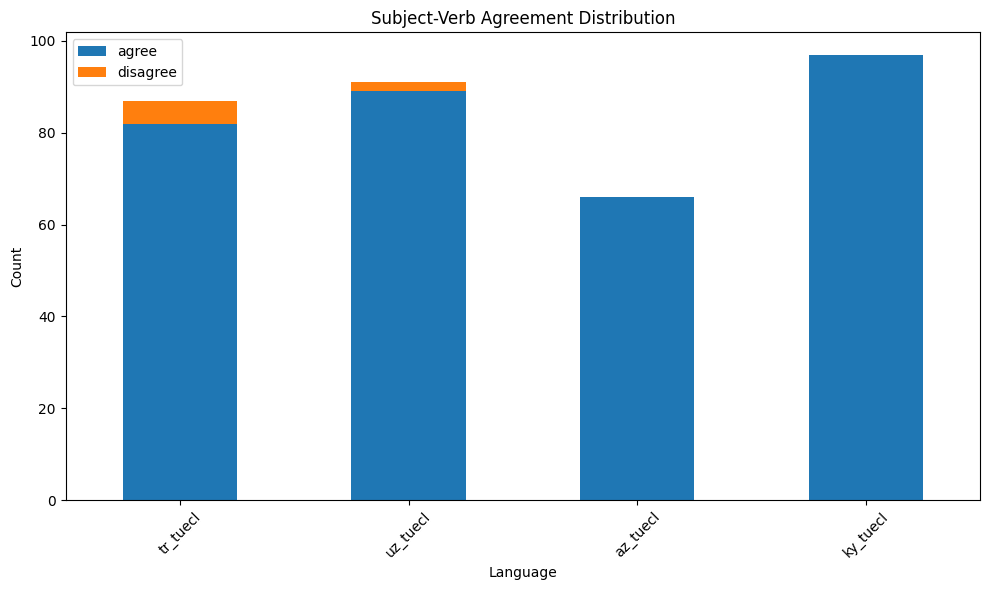

In [13]:
# Plot
df[["agree", "disagree"]].plot(kind="bar", stacked=True, figsize=(10, 6), title="Subject-Verb Agreement Distribution")
plt.ylabel("Count")
plt.xlabel("Language")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()